In [1]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests


/Users/nmayilsa/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
url = "https://imgs.search.brave.com/UvS4hLl9g0Z4mPiPkrgmowZsb0IRm0WbOafB0OaAMzU/rs:fit:860:0:0/g:ce/aHR0cHM6Ly9oZWxp/b3MtaS5tYXNoYWJs/ZS5jb20vaW1hZ2Vy/eS9hcmNoaXZlcy8w/NlZ3M1lKekU4OFpF/TlNZYTI1dmhNSS9o/ZXJvLWltYWdlLmZp/bGwuc2l6ZV8xMjQ4/eDcwMi52MTY0NzAy/NDgxOC5qcGc"


In [4]:
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

In [5]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [6]:
# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

In [7]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )

Detected bench with confidence 0.993 at location [62.43, 396.43, 240.4, 446.75]
Detected car with confidence 0.996 at location [305.93, 370.72, 335.97, 397.68]
Detected car with confidence 0.949 at location [246.09, 366.23, 285.46, 396.24]
Detected car with confidence 0.957 at location [187.41, 365.14, 232.92, 395.73]


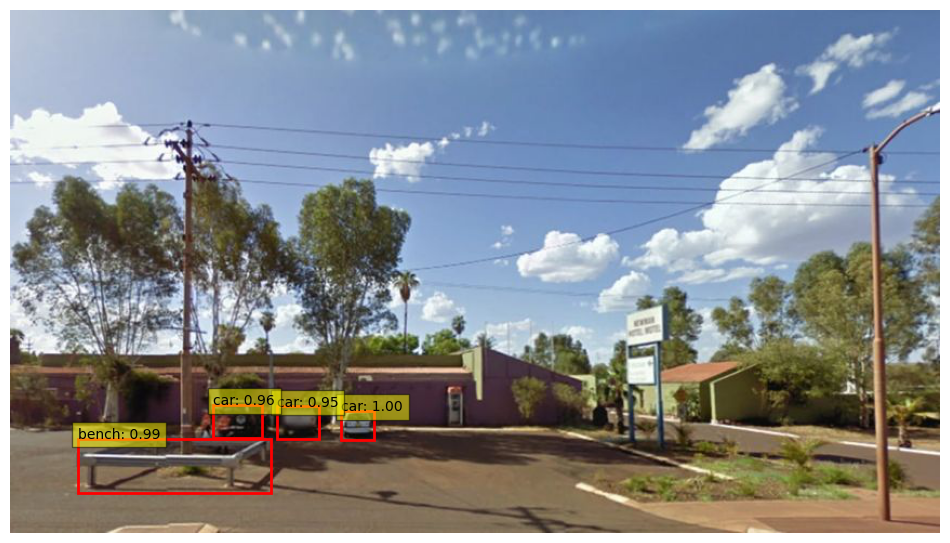

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    label_name = model.config.id2label[label.item()]
    box = box.detach().numpy()
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(box[0], box[1], f"{label_name}: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis("off")
plt.show()


In [9]:
from transformers import AutoImageProcessor, AutoBackbone
import torch
from PIL import Image
import requests

In [10]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
processor = AutoImageProcessor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = AutoBackbone.from_pretrained("microsoft/swin-tiny-patch4-window7-224", out_indices=(1,))

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


/Users/nmayilsa/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Some weights of SwinBackbone were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized: ['swin.hidden_states_norms.stage1.bias', 'swin.hidden_states_norms.stage1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
inputs = processor(image, return_tensors="pt")
outputs = model(**inputs)
feature_maps = outputs.feature_maps

In [12]:
feature_maps

(tensor([[[[ 1.0064e+00,  6.3087e-01, -1.9434e-01,  ...,  3.4310e-01,
             2.3735e-01,  1.6851e-01],
           [ 1.1366e+00,  6.7725e-01, -2.6273e-02,  ..., -1.1405e-01,
             6.0058e-01,  1.7787e-01],
           [ 1.0791e+00,  5.6264e-01,  2.5349e-01,  ...,  2.9255e-01,
             3.0649e-01,  6.1799e-01],
           ...,
           [ 5.0816e-01,  3.7972e-01, -7.7769e-01,  ..., -8.8343e-02,
             5.2977e-02, -5.7092e-01],
           [-3.7535e-01, -1.8946e-01, -3.2584e-01,  ..., -2.9201e-01,
            -5.8429e-02,  1.2849e-01],
           [ 2.5337e-01, -8.9121e-02,  3.7873e-01,  ..., -7.1851e-01,
             1.3847e-01,  5.3692e-01]],
 
          [[ 9.5971e-01,  9.7547e-01,  1.3414e+00,  ...,  8.0082e-01,
             8.1081e-01,  7.8101e-01],
           [ 7.9007e-01,  1.2079e+00,  1.1176e+00,  ...,  9.6235e-01,
             6.2085e-01,  7.4454e-01],
           [ 5.2194e-02,  9.7713e-01,  1.0464e+00,  ...,  7.8407e-01,
             9.2502e-01,  7.9040e-01],


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
sequence = "In a hole in the ground there lived a hobbit."
print(tokenizer(sequence))

{'input_ids': [101, 1999, 1037, 4920, 1999, 1996, 2598, 2045, 2973, 1037, 7570, 10322, 4183, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
